## Regional Satellite / WRF-Chem comparison script

Bulk work, to combine data for each season, rather than plotting a single day at a time.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from matplotlib import ticker
from matplotlib import interactive
import matplotlib as mpl
interactive(True)

import xarray as xr
import numpy as np
import pandas as pd

from scipy import stats
from scipy.interpolate import griddata
import scipy

import cartopy.crs as ccrs
import colorcet as cc

from datetime import timedelta, date
import datetime

In [2]:
# date range function from stackoverflow: 
#   https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python
#   (same source is used for the date range iteration below too)
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [3]:
# loads column and lat/lon data, and converts to panda array.
#    This includes copying the time index to our model data, because
#    I had not added this to the model netcdf files when creating them.
def load_create_dataframe(sat_datadask,model_datadask):

    sat_col_data = sat_datadask.column.copy(deep=True)
    sat_error_data = sat_datadask.error.copy(deep=True)
    sat_vprof_data = sat_datadask.VertProf.copy(deep=True)
    sat_clcov_data = sat_datadask.CLcov.copy(deep=True)
    sat_angle_data = sat_datadask.angle.copy(deep=True)
    lat_data = sat_datadask.latitude.copy(deep=True)
    lon_data = sat_datadask.longitude.copy(deep=True)
    
    # convert from xarray to pandas dataframe
    cold = sat_col_data.to_dataframe()
    errd = sat_error_data.to_dataframe()
    verd = sat_vprof_data.to_dataframe()
    clcd = sat_clcov_data.to_dataframe()
    angd = sat_angle_data.to_dataframe()
    latd = lat_data.to_dataframe()
    lond = lon_data.to_dataframe()
     
    # load the model data, convert to pandas
    model_nh3_data = model_datadask.nh3.copy(deep=True)
    model_date_data = model_datadask.date.copy(deep=True)
    nh3d = model_nh3_data.to_dataframe()
    dat_temp_d = model_date_data.to_dataframe()
    #dat_temp_d.column = ['full_date']
    
    # FUTURE WORK: split the date information into date and hour
    #date2d = dat_temp_d.datetime.strftime('%m/%d/%Y')
    #date2d.column = ['date']
    #hour2d = dat_temp_d.datetime.strftime('%H:%M:%S.%f')
    #hour2d.column = ['time_of_day']
    
    #result_temp = pd.concat([nh3d,dated,hourd,cold,errd,verd,clcd,angd,latd,lond], axis=1, sort=False)
    result_temp = pd.concat([dat_temp_d,nh3d,cold,errd,verd,clcd,angd,latd,lond], axis=1, sort=False)
    
    # switch index from time to date
    result = result_temp.reset_index(drop=False).set_index(['date','latitude','longitude'])

    return result

In [4]:
# Loading data files from a list.
def load_and_combine_list_of_files(satellite_file_path,model_file_path,start_date,end_date):
    
    # initalise list for storing datasets to append
    data_to_append = []  # https://stackoverflow.com/questions/28669482/appending-pandas-dataframes-generated-in-a-for-loop

    for single_date in daterange(start_date, end_date):
        
        date_string = single_date.strftime("%Y%m%d")+'_*'
        satellite_datadask = xr.open_mfdataset(satellite_file_path+'nh3nn_v2_2_'+date_string+'.nc')
        model_datadask = xr.open_mfdataset(model_file_path+'Ammonia_Column_'+date_string+'_gasphase_chemistry.nc')
        
        # load data for the given day
        day_data = load_create_dataframe(satellite_datadask,model_datadask)
        # get rid of empty data points, to save space!
        clean_day_data = day_data.dropna()
        
        # store DataFrame in list
        data_to_append.append(clean_day_data)
    
    
    appended_data = pd.concat(data_to_append, axis=0)
    
    return(appended_data)
    

In [5]:
# groups column data into defined lat/lon bins, takes mean value for each bin, 
#                                and returns the 2D data array of these means
def grid_satellite_model_data(dataframe,lat_bins,lon_bins,lat_mid,lon_mid):
    
    # drop NaN values, and then group into the lat/long bins
    resn = dataframe.dropna()
    #grs = dataframe.groupby([pd.cut(dataframe.latitude,lat_bins),pd.cut(dataframe.longitude,lon_bins)])
    grs = resn.groupby([pd.cut(resn.latitude,lat_bins),pd.cut(resn.longitude,lon_bins)])
    
    # get mean and count values, and reset the indexes for our dataset 
    #     - the longitude and latitude bins will now be column data rather than indexes
    grmean  = grs.column.mean().reset_index()
    grcount = grs.column.count().reset_index()
    grnh3mean = grs.nh3.mean().reset_index()
    
    # determine spatial correlation stats for each grid cell. 
    #   First create template array from mean of grouped data (without dropping lat/lon indexes)
    #   Then step through the groups, calculating the spearman stats for each (and saving info in arrays)
    #   Finally, drop the lat/lon indexes
    spear_corr = grs.column.mean()
    spear_pval = spear_corr.copy(deep=True)
    for key, group in grs:
        spear_corr.loc[(key[0].mid,key[1].mid)] = stats.spearmanr(group.column,group.nh3).correlation
        spear_pval.loc[(key[0].mid,key[1].mid)] = stats.spearmanr(group.column,group.nh3).pvalue
    spear_corr = spear_corr.reset_index()
    spear_pval = spear_pval.reset_index()
    
    
    # determine the grid centre locations from the grid information for the dataset
    grmean['Mid_Lon'] = grmean['longitude'].apply(lambda x: x.mid)
    grmean['Mid_Lat'] = grmean['latitude'].apply(lambda x: x.mid)
    grnh3mean['Mid_Lon'] = grnh3mean['longitude'].apply(lambda x: x.mid)
    grnh3mean['Mid_Lat'] = grnh3mean['latitude'].apply(lambda x: x.mid)

    print(np.max(grmean['Mid_Lon']))
    print(np.min(grmean['Mid_Lon']))
    print(np.max(grmean['Mid_Lat']))
    print(np.min(grmean['Mid_Lat']))
    
    # create 2D mesh for storing extracted data 
    lon_grid, lat_grid = np.meshgrid(lon_mid,lat_mid)
    
    
    
    col_grid = np.full_like(lon_grid, np.nan)
    nh3_grid = np.full_like(lon_grid, np.nan)
    count_grid = np.full_like(lon_grid, np.nan)
    sp_corr_grid = np.full_like(lon_grid, np.nan)
    sp_pval_grid = np.full_like(lon_grid, np.nan)

    
    # grid the model data (and counts)
    for ix,iy in np.ndindex(lon_grid.shape):
        if any(grmean.column[(grmean.Mid_Lat == lat_grid[ix,iy]) & (grmean.Mid_Lon == lon_grid[ix,iy])]):
            col_grid[ix,iy] = np.asscalar(grmean.column[(grmean.Mid_Lat == lat_grid[ix,iy]) & (grmean.Mid_Lon == lon_grid[ix,iy])])
            nh3_grid[ix,iy] = np.asscalar(grnh3mean.nh3[(grmean.Mid_Lat == lat_grid[ix,iy]) & (grmean.Mid_Lon == lon_grid[ix,iy])])
            count_grid[ix,iy] = np.asscalar(grcount.column[(grmean.Mid_Lat == lat_grid[ix,iy]) & (grmean.Mid_Lon == lon_grid[ix,iy])])    
            sp_corr_grid[ix,iy] = np.asscalar(spear_corr.column[(grmean.Mid_Lat == lat_grid[ix,iy]) & (grmean.Mid_Lon == lon_grid[ix,iy])])
            sp_pval_grid[ix,iy] = np.asscalar(spear_pval.column[(grmean.Mid_Lat == lat_grid[ix,iy]) & (grmean.Mid_Lon == lon_grid[ix,iy])])

    
    
    
    # grid the model data (and counts)
    #col_grid = griddata((grmean.Mid_Lon,grmean.Mid_Lat),grmean.column,(lon_grid,lat_grid))
    #nh3_grid = griddata((grnh3mean.Mid_Lon,grnh3mean.Mid_Lat),grnh3mean.nh3,(lon_grid,lat_grid))
    #count_grid = griddata((grmean.Mid_Lon,grmean.Mid_Lat),grcount.column,(lon_grid,lat_grid))
    #sp_corr_grid = griddata((grmean.Mid_Lon,grmean.Mid_Lat),spear_corr.column,(lon_grid,lat_grid))
    #sp_pval_grid = griddata((grmean.Mid_Lon,grmean.Mid_Lat),spear_pval.column,(lon_grid,lat_grid))
    
    return col_grid, nh3_grid, lon_grid, lat_grid, count_grid, sp_corr_grid, sp_pval_grid


#### Load satellite and model data

The 'time' index in the satellite data is 'UTC time of acquisition', in units 'HHMMSS.ms', so I think that we need to be careful to only load data for a single day at a time for this processing. Otherwise the coordinate system could become confused by duplicate values for each day. This doesn't matter for the global satellite data plots, but for this work we are merging model and satellite data, and so we need to be more careful with indexing.

In [6]:
root_path = '/Users/mbessdl2/Documents/Clearflo_data_analysis/'
satellite_file_path = root_path+'satellite_data/'
model_file_path = root_path+'model_column_data/'

# summer
start_date = date(2012, 7, 30)
end_date = date(2012, 8, 23)
#start_date = date(2012, 8, 15)
#end_date = date(2012, 8, 20)
# winter
#start_date = date(2012, 1, 8)
#end_date = date(2012, 2, 11)



In [7]:
work_data = load_and_combine_list_of_files(satellite_file_path,model_file_path,start_date,end_date)

/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/xarray/coding/variables.py:138: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/xarray/coding/variables.py:138: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/xarray/coding/variables.py:138: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/xarray/coding/variables.py:138: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/Users/m

In [8]:
work_data

time  \
date                          latitude  longitude                   
2012-07-31 08:30:36.999892992 59.045609  13.389850   83037.179688   
                              58.799381  13.343570   83037.179688   
2012-07-31 08:30:44.999313408 58.539120  14.076880   83045.171875   
2012-07-31 08:30:52.998733824 57.942299  10.830850   83053.390625   
2012-07-31 08:31:00.998153216 57.750160  10.816420   83101.398438   
                              57.713150  11.733120   83101.398438   
2012-07-31 08:31:08.997573632 57.019150  10.731670   83109.390625   
2012-07-31 08:31:24.999846912 56.016720  12.860520   83125.179688   
2012-07-31 08:31:32.999267328 55.798618  12.826310   83133.179688   
                              55.900291  10.610560   83133.398438   
                              55.631321  10.575930   83133.398438   
                              55.599121  11.446840   83133.398438   
2012-07-31 08:31:40.998687744 55.437599  10.554720   83141.390625   
                              55.168652  10.519780   83141.390625   
                              55.397129  11.416150   83141.390625   
2012-07-31 08:31:48.998108160 54.870491  12.668100   83149.179688   
                              54.624580  12.623030   83149.179688   
                              54.976879  10.502840   83149.398438   
                              54.707989  10.467620   83149.398438   
                              54.674351  11.318280   83149.398438   
2012-07-31 08:31:56.997528576 54.407581  12.590300   83157.179688   
                              54.161732  12.545330   83157.179688   
                              54.514118  10.450950   83157.390625   
                              54.245300  10.415410   83157.390625   
                              54.210972  11.256120   83157.390625   
                              54.472191  11.292060   83157.390625   
2012-07-31 08:32:05.000381440 53.943169  12.509580   83205.171875   
                              54.053082  10.399230   83205.390625   
                              54.010399  11.230540   83205.390625   
2012-07-31 08:32:13.003235328 53.318981  10.303190   83213.390625   
...                                                           ...   
2012-08-22 22:25:35.998534656 46.279980 -12.964290  222536.000000   
                              46.415791 -11.569330  222536.203125   
                              46.596802 -9.193340   222536.421875   
                              46.865059 -9.228530   222536.421875   
                              46.811859 -9.942660   222536.421875   
                              46.551559 -9.901750   222536.421875   
2012-08-22 22:25:43.997955072 47.015839 -9.970370   222544.421875   
2012-08-22 22:25:50.994873344 47.485500 -12.703490  222551.984375   
2012-08-22 22:25:51.997375488 47.586391 -11.782980  222552.203125   
                              47.346920 -11.737920  222552.203125   
2012-08-22 22:25:59.996795904 48.103458 -11.268920  222600.203125   
                              47.812801 -11.822460  222600.203125   
2012-08-22 22:26:07.996216320 48.568001 -11.348540  222608.203125   
                              48.517220 -11.952790  222608.203125   
2012-08-22 22:26:15.995635712 48.787209 -11.385420  222616.203125   
2012-08-22 22:28:06.998749184 54.913132 -17.154860  222807.593750   
2012-08-22 22:28:15.005035520 55.335129 -17.748720  222815.593750   
2012-08-22 22:28:24.000091136 56.588261 -10.439300  222824.453125   
2012-08-22 22:28:31.999511552 56.750858 -11.356140  222832.453125   
2012-08-22 22:28:39.998931968 57.389488 -12.851320  222840.234375   
                              57.345631 -13.596490  222840.234375   
2012-08-22 22:28:48.005218304 57.606571 -12.891660  222848.234375   
2012-08-22 22:28:56.004638720 57.913582 -15.551400  222856.015625   
2012-08-22 22:29:03.001555968 58.508301 -16.747410  222903.796875   
2012-08-22 22:29:04.004059136 58.899200 -10.689960  222904.453125   
2012-08-22 22:29:20.002898944 59.666111 -14.053230  222920.

### Data regridding

Cleaning:
* I drop any NaN's in the data (both to zoom into the model domain, as work_data.nh3 will be NaN outside of this, and to get rid of the missing values in the satellite data, where work_data.column is a NaN). 


Mapping:
* Both model and satellite data will be mapped onto a fixed lat/lon grid, of resolution 0.5 degrees.

In [19]:
# create the edge values for our lat/lon bins
#lat_bins = np.arange(36,70,2.0)
#lon_bins = np.arange(-30,30,2.0)
#lat_mid = np.arange(37,71,2.0)
#lon_mid = np.arange(-29,31,2.0)
#lat_bins = np.arange(42,64,2.0)
#lon_bins = np.arange(-24,18,2.0)
#lat_mid = np.arange(43,65,2.0)
#lon_mid = np.arange(-25,19,2.0)

lat_bins = np.arange(36,71,1.0)
lon_bins = np.arange(-30,31,1.0)
lat_mid = np.arange(36.5,70.5,1.0)
lon_mid = np.arange(-29.5,30.5,1.0)

#lat_bins = np.arange(44,60,0.5)
#lon_bins = np.arange(-20,15,0.5)
#lat_mid = np.arange(44.25,60.25,0.5)
#lon_mid = np.arange(-20.25,15.25,0.5)

#lat_bins = np.arange(36,71,0.5)
#lon_bins = np.arange(-30,31,0.5)
#lat_mid = np.arange(36.25,70.25,0.5)
#lon_mid = np.arange(-29.75,30.25,0.5)

#lat_bins = np.arange(43,64,0.5)
#lon_bins = np.arange(-20,17,0.5)
#lat_mid = np.arange(43.25,63.75,0.5)
#lon_mid = np.arange(-21.25,16.75,0.5)



wdata = work_data.reset_index(level=[1,2])

sat_grid, mod_grid, lon_grid, lat_grid, test_count, sp_corr, sp_pval = grid_satellite_model_data(wdata,lat_bins,lon_bins,lat_mid,lon_mid)


16.5
-21.5
63.5
43.5


### Data plotting

Plotting of model vs satellite relationship, for the subgroups defined above.

First set of plots is without weighting by the satellite errors, second set of plots is with this weighting.

In each plot the linear correlation line is given, along with dashed lines indicating the bounds of the one standard deviation uncertainty in slope and intercept.



In [26]:
# data cleaning

#sat_grid_2 = sat_grid.loc[test_count<10]

test_count_2 = np.where(np.isnan(test_count),0,test_count)
sat_grid_2 = np.where(test_count_2<20,np.nan,sat_grid)
mod_grid_2 = np.where(test_count_2<20,np.nan,mod_grid)
mod_grid_2 = np.where(test_count_2<20,np.nan,mod_grid)
sp_corr_2  = np.where(test_count_2<20,np.nan,sp_corr)
sp_pval_2  = np.where(test_count_2<20,np.nan,sp_pval)
#test_count_2.sum()

sat_grid_2.max()

/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


nan

nan

In [56]:
def map_plot(data,lon_g,lat_g,ax_ind,titlestring,cbar_label,plt,clim,plim,cmap):
    ax = plt.subplot(ax_ind[0], ax_ind[1], ax_ind[2], projection=ccrs.PlateCarree())
    #ax = plt.subplot(ax_ind[0], ax_ind[1], ax_ind[2], projection=ccrs.LambertConformal(central_longitude=-2.417999,central_latitude=53.915))
    ax.coastlines('50m')
    #ax.coastlines()


    cf = ax.pcolormesh(lon_g,lat_g,data,vmin=clim[0],vmax=clim[1],cmap=cmap)
    ax.set_title(titlestring)

    # colormap control code taken from here: https://stackoverflow.com/questions/3373256/set-colorbar-range-in-matplotlib
    ax_cbar, _ = mpl.colorbar.make_axes(ax, shrink=0.7)
    cbar = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap, norm=mpl.colors.Normalize(vmin=plim[0],vmax=plim[1]))
    cbar.set_clim(clim[0],clim[1])
    cbar.set_label(cbar_label)
    
    ax.set_extent([-20, 17, 43, 65], ccrs.PlateCarree())
    

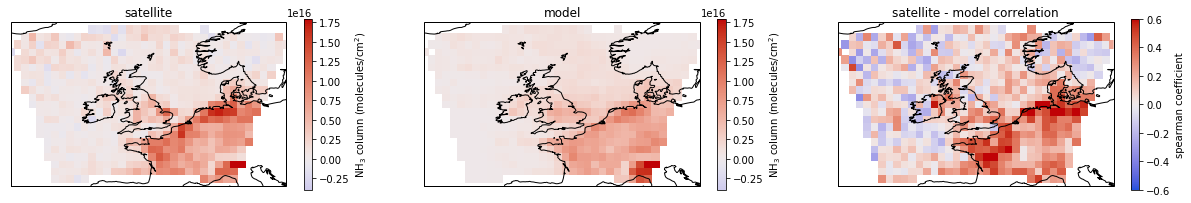

In [67]:
# main paper figure    
    
plt.figure(figsize=(21, 4.5))
map_plot(sat_grid_2,lon_grid,lat_grid,[1,3,1],'satellite',r'NH$_3$ column (molecules/cm$^2$)',plt,[-1.8e16,1.8e16],[-0.4e16,1.8e16],cc.cm.coolwarm)
map_plot(mod_grid_2,lon_grid,lat_grid,[1,3,2],'model',r'NH$_3$ column (molecules/cm$^2$)',plt,[-1.8e16,1.8e16],[-0.4e16,1.8e16],cc.cm.coolwarm)
map_plot(sp_corr_2,lon_grid,lat_grid,[1,3,3],"satellite - model correlation","spearman coefficient",plt,[-0.6,0.6],[-0.6,0.6],cc.cm.coolwarm)


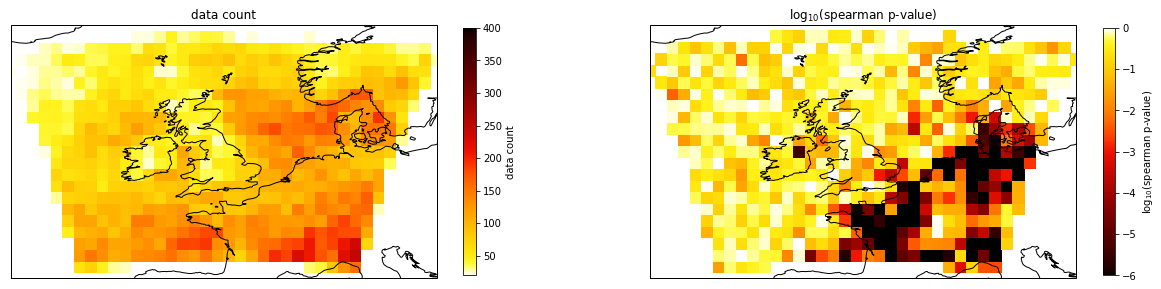

In [69]:
# supplementary material figure    
    
plt.figure(figsize=(21, 6.5))
map_plot(test_count_2,lon_grid,lat_grid,[1,2,1],"data count","data count",plt,[20,400],[20,400],cc.cm.fire_r)
map_plot(np.log10(sp_pval_2),lon_grid,lat_grid,[1,2,2],r'log$_{10}$(spearman p-value)',r'log$_{10}$(spearman p-value)',plt,[-6,0],[-6,0],cc.cm.fire)

In [12]:
plt.subplot?

In [13]:
cc.cm.coolwarm